# Electron Population Parameters
By fitting the electron population to Coma Radio spectrum data, find normalization and index parameters
- Results: [2.07162116e-14 3.81371533e+00]



In [1]:
from matplotlib.colors import SymLogNorm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates.sky_coordinate import SkyCoord
import astropy.units as u
from astropy.cosmology import Planck15 as cosmo
from astropy import constants as const
from astropy.wcs import WCS
from ClusterModel import model
from ClusterModel import model_modpar
from ClusterModel import model_tools

# Modify plotting parameters
dict_base = {'font.size':        16,
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

In [2]:
clust = model.Cluster(name='Coma', 
                      redshift=0.023, M500=7e14*u.Msun, 
                      cosmology=cosmo, silent=False, 
                      output_dir='/home/astrogamma/Project/Output/TestClusterModel')

                 __  __ ___ ___   _   ___   ___                 
                |  \/  |_ _/ __| /_\ |   \ / _ \                
                | |\/| || | (__ / _ \| |) | (_) |               
                |_|  |_|___\___/_/ \_\___/ \___/                
 Modeling the Intra Cluster Atmosphere for Diverse Observations 
----------------------------------------------------------------
                                                                
Setting gNFW Planck coll. (2013) UPP.


In [3]:
#----- Some parameters that can be set at when defining the cluster
clust.coord = SkyCoord("194.953d  27.9806d", frame="icrs", unit="deg")

#----- Define the relevant ICM model (available models are defined in model_modpar.py)

# Density profile of the target thermal gas
clust.density_gas_model = {'name':'beta', 'n_0':3e-3*u.cm**-3, 'beta':2.0/3, 'r_c':290*u.kpc}

# Pressure profile of the target thermal gas
clust.pressure_gas_model = {'name':'GNFW', 'P_0':2.2e-2*u.keV/u.cm**3, 'c500':2.9, 'a':1.8, 'b':3.1, 'c':0.0}

# Set the cosmic ray density profile to the same shape as the thermal gas density
clust.set_density_crp_isodens_scal_param()

# Cosmic ray proton spectrum
clust.spectrum_crp_model = {'name':'PowerLaw', 'Index':2.3}

# Cosmic ray proton normalization
clust.X_cr_E = {'X':0.01, 'R_norm':clust.R500} # X is the CRp/thermal energy ratio, normalized within R_norm


#Set some random stolen models for the primary electrons
clust.spectrum_cre1_model = {'name':  'PowerLaw', 'Index':2.3}
                             #'ExponentialCutoffPowerLaw','Index':3.3, 'CutoffEnergy':1e7*u.keV}
                           
                        
## You can try building a model incorporating the energy losses from sync and IC!


## For density you can just make the same as protons --> set it equal to the thermal gas 
clust.density_cre1_model = {'name': 'beta', 'n_0':3e-3*u.cm**-3, 'beta':2.0/3, 'r_c':290*u.kpc}

#pull out some random min and max energies
Eemin = (const.m_e *const.c**2).to('GeV')
#clust.Epmin 
Eemax = clust.Epmax

Setting coord value
Setting density_gas_model value
Fixing: R500
Setting pressure_gas_model value
Fixing: R500
Setting spectrum_crp_model value
Getting R500 value
Setting cosmic ray to thermal pressure ratio value
Getting the maximal proton energy


In [5]:
## Just use the avalialble generic functions

clust.density_cre1_model['n_0'] = 1.0 *u.adu

def get_normed_density_cre1_profile(cl = clust, rad = np.logspace(0,4,100)*u.kpc):
    
   # rad = model_tools.check_qarray(rad, unit = 'kpc')
    nr = cl._get_generic_profile(rad, cl.density_cre1_model)
    nr[rad > cl._R_truncation] *= 0 
    
    return rad, nr.to('adu')


def get_normed_spectrum_cre1(cl , en): 
    
    se = cl._get_generic_spectrum(en, cl.spectrum_cre1_model)
    se[en >Eemax] *= 0
    se[en <Eemin] *= 0
    
    return en, se*u.adu

In [6]:
A = 1/u.GeV/u.cm**3

def cre1_2d(cl = clust, en= np.logspace(-2,7,100)*u.GeV, rd =np.logspace(0,4,100)*u.kpc):
    
    #norm
    #r = norm_electrons(clust)
    #norm_electrons(cl)
    #spatial
    rad, fd = get_normed_density_cre1_profile(cl, rd)
    fd2 = model_tools.replicate_array(fd.to_value('adu'), len(en), T = False )
    #energy
    eng, fe = get_normed_spectrum_cre1(cl, en)
    fe2 = model_tools.replicate_array(fe.to_value('adu'), len(rd), T = True )
    
    spectrum= A*fd2*fe2
     
    return spectrum.to('GeV-1 cm-3')


# Parameterize Norm Externally for the Fit
- First just try to see if it makes sense

In [8]:
### Basic Synchrotron Rate Function 


from ClusterModel.ClusterTools import cluster_electron_emission as emi


def rate_sync(energy = np.logspace(-9,-2,100)*u.eV, radius = np.logspace(0,4,100)*u.kpc ):
    
    #Get Magnetic field
    radius, B = clust.get_magfield_profile(radius)
    
    #Define Je: 
    def Je2(rad, eng): return cre1_2d(clust, eng*u.GeV, rad*u.kpc).to_value('GeV-1 cm-3').T


    #rad*u.kpc
    
    
    #Use the class
    model =  emi.ClusterElectronEmission (Je = Je2,Eemin=(const.m_e*const.c**2).to('GeV'), NptEePd=clust._Npt_per_decade_integ)
    rate = model.synchrotron( energy, radius_input = radius, B=B).T
    
    return rate.to('GeV-1 cm-3 s-1')

## Multiply the result by a custom Norm

In [9]:
default = clust.get_rate_synchrotron()
dN_dEdVdt = rate_sync()

## Mock Norm multiplies it externally 
B = 0.0001
tryme = B*rate_sync()

Text(0.5,1,'Rate for Primary Electrons')

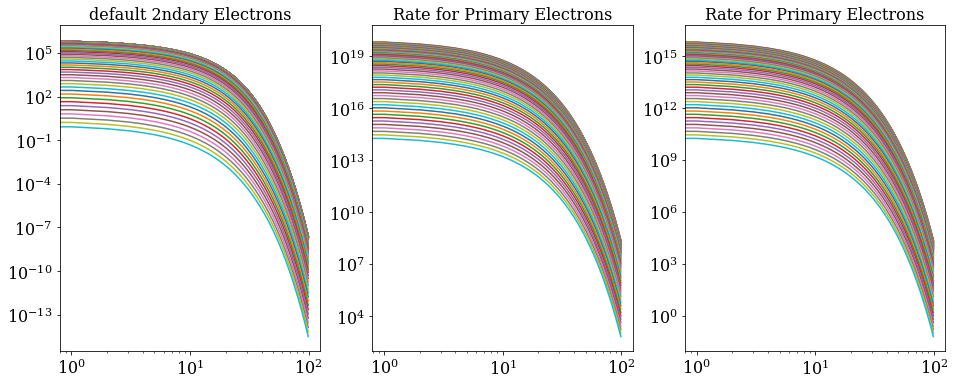

In [10]:
plt.figure(figsize=(15,6))
plt.subplot(131)
plt.loglog(default)
plt.title("default 2ndary Electrons")

plt.subplot(132)
plt.loglog(dN_dEdVdt)
plt.title("Rate for Primary Electrons")


plt.subplot(133)
plt.loglog(tryme)
plt.title("Rate for Primary Electrons")


In [95]:
def sync_spectrum( freq = np.logspace(-3,2,100)*u.GHz, norm = 1, ind = 2.3 ):
    
    '''Uses Primary Electron population via rate_sync() and multiplies the result by the norm
    '''
    
    #Get energy
    #freq = model_tools.check_qarray(freq, unit='GHz')
    energy = (const.h*freq).to('eV')
    
 
    Rmin = clust._Rmin
    
    Rmax = clust._R500
        
    clust.spectrum_cre1_model = {'name':  'PowerLaw', 'Index':ind}


    #sample radius
    rad = model_tools.sampling_array(Rmin, Rmax, NptPd = clust._Npt_per_decade_integ, unit = True)
    #Use rate sync to get synchotron rate
   
    dNdEdVdt = rate_sync(energy, rad)
    #integrate spherically
    dNdEdt = model_tools.spherical_integration(norm * dNdEdVdt, rad)
    
    #This gave us luminosity; now get flux 
    dNdEdSdt = dNdEdt / (4*np.pi * clust._D_lum**2)
    
    #Convert to Jy 
    return freq, (dNdEdSdt*energy**2 / freq).to('Jy')


def sync_spectrum2( freq = np.logspace(-3,2,100)*u.GHz, norm = 1):
    
    '''This one uses the Secondary Electron population
    '''
    
    #Get energy
    #freq = model_tools.check_qarray(freq, unit='GHz')
    energy = (const.h*freq).to('eV')
    
 
    Rmin = clust._Rmin
    
    Rmax = clust._R500
        
        
    #sample radius
    rad = model_tools.sampling_array(Rmin, Rmax, NptPd = clust._Npt_per_decade_integ, unit = True)
    #Use rate sync to get synchotron rate
   
    dNdEdVdt = clust.get_rate_synchrotron(energy, rad)
    #integrate spherically
    dNdEdt = model_tools.spherical_integration(norm * dNdEdVdt, rad)
    
    #This gave us luminosity; now get flux 
    dNdEdSdt = dNdEdt / (4*np.pi * clust._D_lum**2)
    
    #Convert to Jy 
    return freq, (dNdEdSdt*energy**2 / freq).to('Jy')

### Sanity Check 
Plot along with the automatic one

Text(0.5,1,'new')

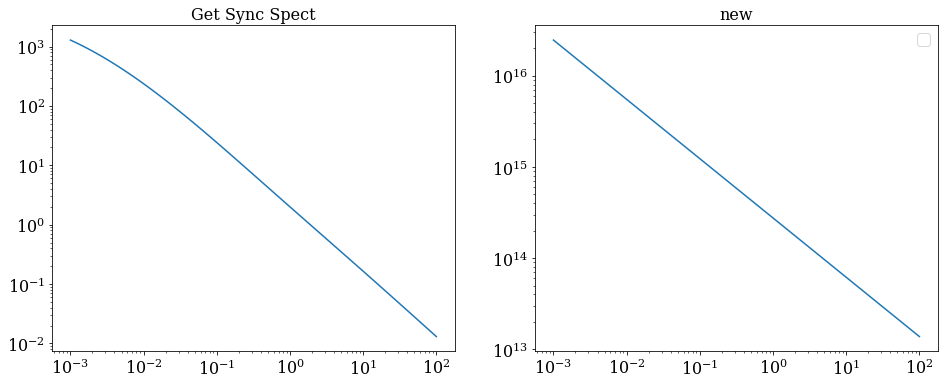

In [96]:
plt.figure(figsize = (15,6))
plt.subplot(121)
### Automatic function
frequency, readyspectrum = clust.get_synchrotron_spectrum()
plt.loglog(frequency,readyspectrum)
plt.title("Get Sync Spect")

#New one 
plt.subplot(122)
frequency, spectrum = sync_spectrum()
frequency, spectrum2 = sync_spectrum2()
plt.loglog(frequency, spectrum)
#plt.loglog(frequency, spectrum2, label = "secondary")
plt.legend()

plt.title("new")


# Coma Data

In [13]:
# Radio total flux [Thierbach et al (2003)]:

dat_freq = np.array([30.9,43,73.8,151,326,408,430,608.5,1380,1400,2675,2700,4850])*u.MHz
dat_flux = np.array([49,51,17,7.2,3.81,2.0,2.55,1.2,0.53,0.64,0.11,0.07,0.03])*u.Jy
dat_err  = np.array([10,13,12,0.8,0.03,0.2,0.28,0.3,0.05,0.035,0.03,0.02,0.01])*u.Jy

## Use Different Norms using dat freq

In [14]:

## Different Norms : 0.001 and 0.1
freq2, spectrum1 = sync_spectrum(dat_freq, 1e-13)
freq2, spectrum2 = sync_spectrum(dat_freq, 1e-10)


## Plot for Primary and Secondary Electron Populations
- With primary, try different normalizations

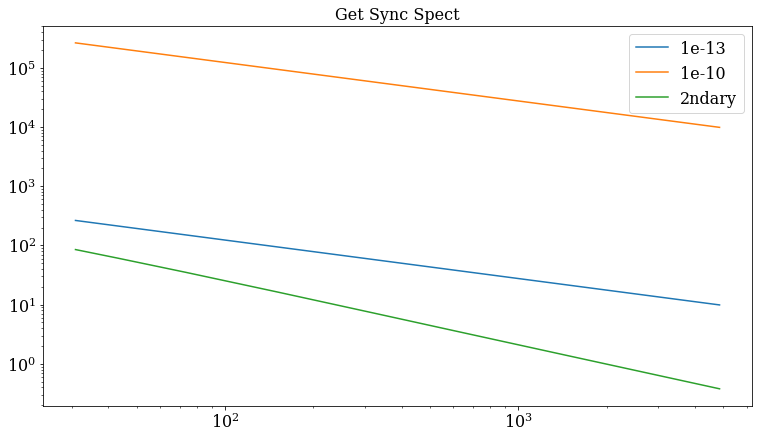

In [15]:
plt.figure(figsize = (12,7))
### Automatic function
plt.loglog(dat_freq,spectrum1, label = "1e-13")
plt.title("Get Sync Spect")

#New one 
plt.loglog(dat_freq, spectrum2, label = "1e-10")
frequency, readyspectrum = clust.get_synchrotron_spectrum(dat_freq)
frequency, spectrum2nd = sync_spectrum2(dat_freq)
plt.loglog(frequency,spectrum2nd, label = "2ndary")
plt.legend()

## With Data and Simple Power Law

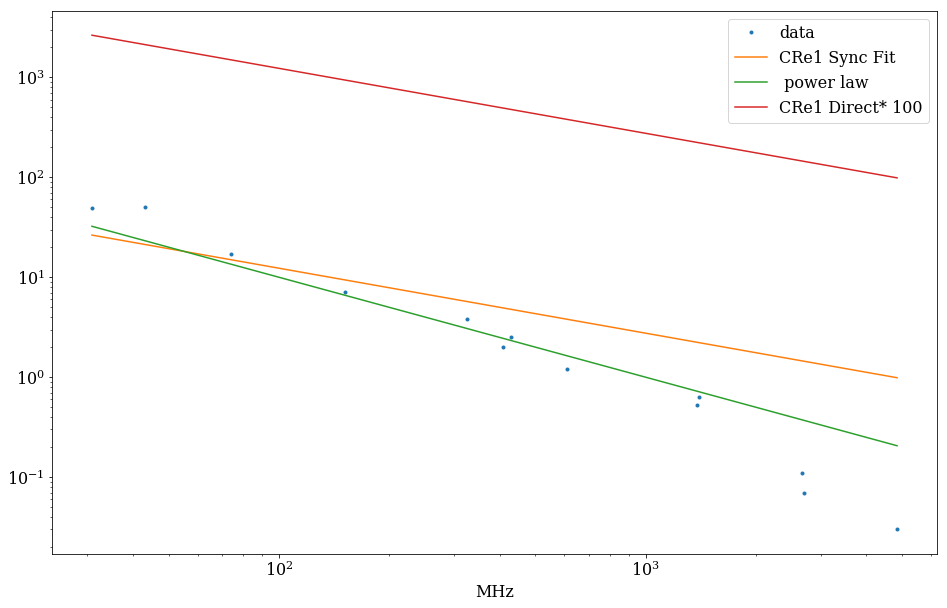

In [16]:


#Primary Electron Population, custom Norm 
dat_freq, spectrum = sync_spectrum(dat_freq, 1e-14)

## SyncFit , norm set 
def syncfit(x):
    return sync_spectrum(x,1e-14)[1]

## Regular Power Law
def fitfunc(x):
    return 10**3*(x)**(-1)

trial = fitfunc(dat_freq)
trial2 = syncfit(dat_freq)

plt.figure(figsize=(15,10))

##DATA
plt.loglog(dat_freq,dat_flux,".", label = "data")
#PRIMARY Sync Fit
plt.loglog(dat_freq, trial2, "-", label = "CRe1 Sync Fit ")
#Regular Power Law
plt.loglog(dat_freq, trial,label =  " power law")
#Primary, direct
plt.loglog(dat_freq, 100*spectrum , label = "CRe1 Direct* 100")


plt.xlabel(frequency.unit)
plt.legend()
plt.show()

In [ ]:
def syncfit(x,a):
    return sync_spectrum(x,a)[1]

syncfit(dat_freq, 1)

# The Fits 
_______________________________________________________________________________________________________________

### Fit Power Law as Before
Verifying that it works, include errors 

In [82]:
from scipy import optimize


## Sync Spectrum will be identicql to the one from "electrons", but with norm as a parameter
def syncfit(x,a):
    sync_spectrum(a,x)

def fitfunc(x, a, b):
    return a*(x)**b

params, params_covariance = optimize.curve_fit(fitfunc, dat_freq, dat_flux, sigma = dat_err,
                                               p0=[2, 2])

print(params)

[ 1.28845402e+04 -1.40686829e+00]


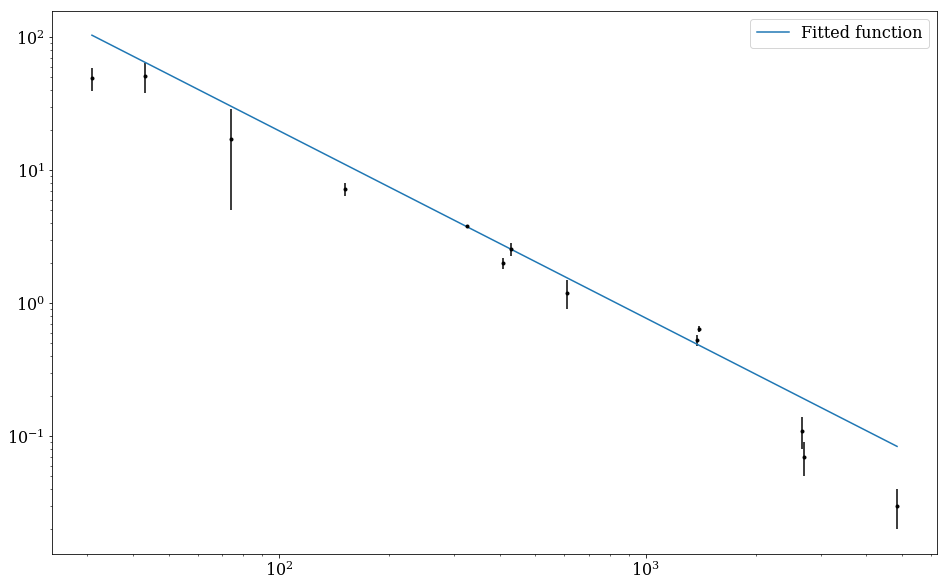

In [85]:
plt.figure(figsize=(15, 10))


#plt.scatter(dat_freq, dat_flux, label='Data')
plt.errorbar(dat_freq.to_value('MHz'), dat_flux.to_value('Jy'), yerr = dat_err.to_value('Jy') , fmt="k.")

plt.loglog(dat_freq, fitfunc(dat_freq, params[0], params[1]),
         label='Fitted function')


plt.legend(loc='best')

plt.show()

In [79]:
popt, pcov = optimize.curve_fit(fitfunc, dat_freq, dat_flux, sigma =dat_err)
print(popt)

[ 1.28847630e+04 -1.40687126e+00]


## Fit Sync Fit


In [87]:
from scipy import optimize

#dat_freq2 = dat_freq.to('GHz')



## Sync Spectrum will be identical to the one from "electrons", but with norm as a parameter
## SyncFit , norm set 


def syncfit(x,a, b):
    return sync_spectrum(x*u.GHz,a, b)[1].to_value('Jy')



params, params_covariance = optimize.curve_fit(syncfit, dat_freq.to_value('GHz'), dat_flux.to_value('Jy'), sigma = dat_err.to_value('Jy'),
                                               p0=[0, 2])

print(params)

[2.07162116e-14 3.81371533e+00]


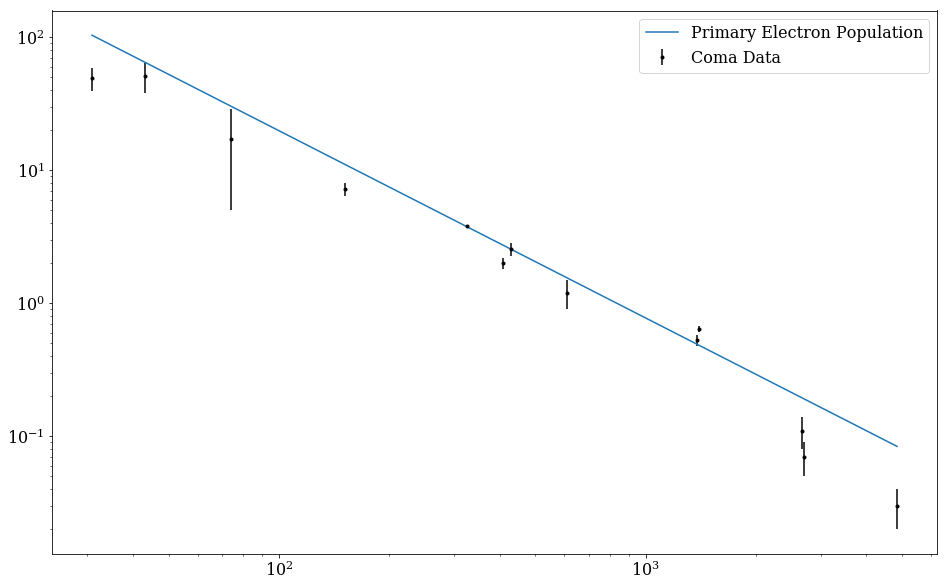

In [90]:
plt.figure(figsize=(15, 10))
plt.errorbar(dat_freq.to_value('MHz'), dat_flux.to_value('Jy'), yerr = dat_err.to_value('Jy') , fmt="k.", label = "Coma Data")
#plt.scatter(dat_freq, dat_flux, label='Data')
plt.loglog(dat_freq, syncfit(dat_freq.to_value('GHz'), params[0],params[1]),
         label='Primary Electron Population')

plt.legend(loc='best')

plt.show()

# Fit with Leastsq!!!
Look at the chi2 values

Fit Converged
('Converged with chi-squared ', 168.86408036844796)
('Number of degrees of freedom, dof =', 11)
('Reduced chi-squared ', 15.35128003349527)
Inital guess values:
('  p0 =', [2278.34835, -1.08423216])
Best fit values:
('  pf =', array([3.44292420e-10, 3.81374083e+00]))
Uncertainties in the best fit values:
('  pferr =', [5.43883325797878e-11, 0.039602402293125866])
('residuals =', array([-5.42513619e+01, -1.38628234e+01, -1.33361920e+01, -3.87990636e+00,
        5.76546352e-02, -7.36615262e-01,  8.29330589e-03, -3.59482301e-01,
        3.71993208e-02,  1.57074836e-01, -8.42110128e-02, -1.21685882e-01,
       -5.40839840e-02]))



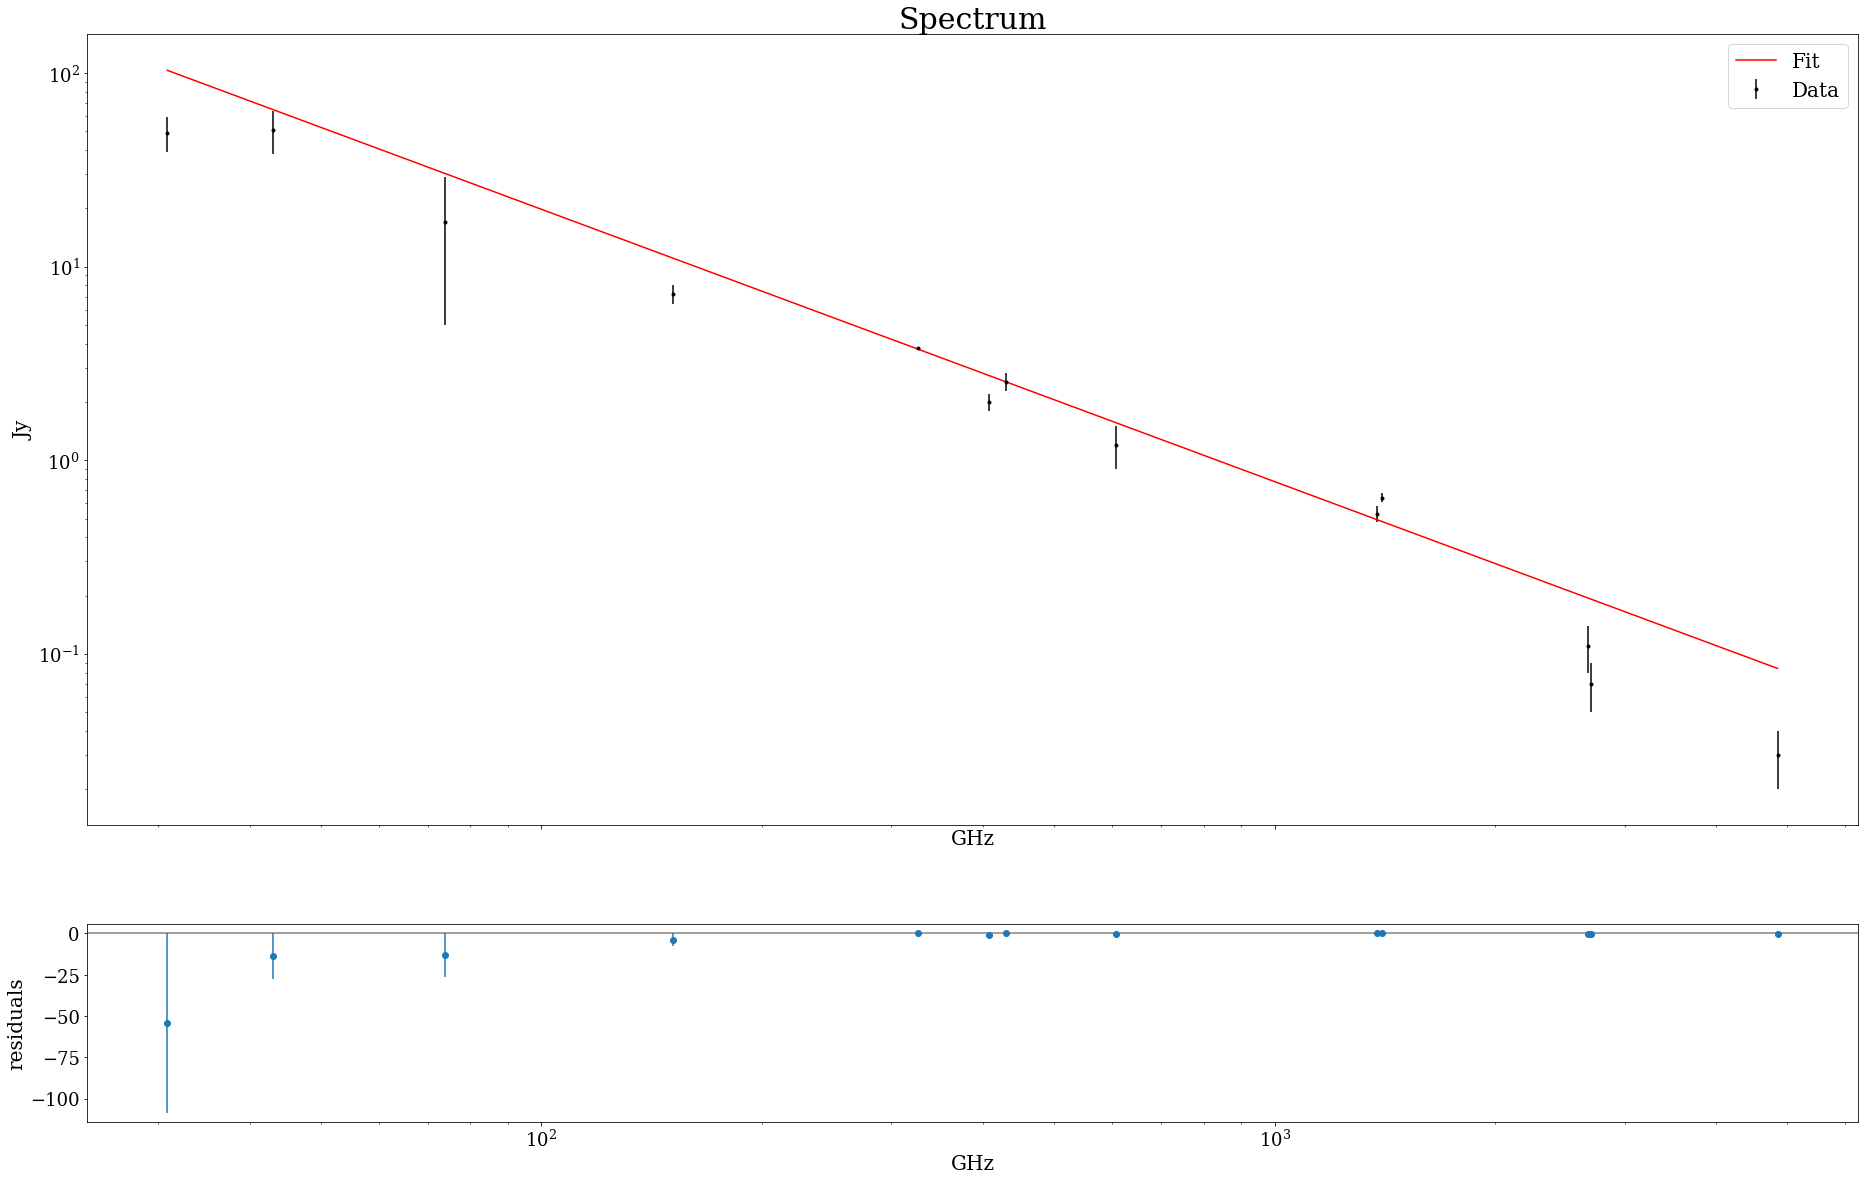

In [97]:

import matplotlib.gridspec as gridspec


def syncfit4(p,x):
    return sync_spectrum(x*u.GHz,p[0], p[1])[1].to_value('Jy')

def residual2(p, x, y, dy):
    return (syncfit4(p,x)-y)/dy

y = dat_flux.to_value('Jy')
x = dat_freq.to_value('MHz')
p02 = [ 2.27834835e+03,-1.08423216e+00]
dy = dat_err.to_value('Jy')
pf2, cov2, info2, mesg2, success2 = optimize.leastsq(residual2, p02, args = (x, y, dy), full_output=1)
pf2_f, pf2_a = pf2
if success2 <= 4:
    print("Fit Converged")
    chisq2 = sum(info2["fvec"]*info2["fvec"])
    dof2 = len(x)-len(pf2)
    pferr2 = [np.sqrt(cov2[i,i]) for i in range(len(pf2))]
    diff = np.array(y - syncfit4(pf2, x))
    print("Converged with chi-squared ", chisq2)
    print("Number of degrees of freedom, dof =",dof2)
    print("Reduced chi-squared ", chisq2/dof2)
    print("Inital guess values:")
    print("  p0 =", p02)
    print("Best fit values:")
    print("  pf =", pf2)
    print("Uncertainties in the best fit values:")
    print("  pferr =", pferr2)
    print("residuals =", diff)
    print
    
    
    
    f, (ax1, ax2) = plt.subplots(nrows =2,sharex = True, figsize = (30,20),gridspec_kw={'height_ratios': [4,1]} )


    yerr = dy
    ax1.errorbar(x, y, yerr, fmt='k.', label = 'Data')
    #T = np.linspace(x.min(), x.max(), 2000)
    ax1.plot(x, syncfit4(pf2, x), 'r-', label = 'Fit')
    
   # ax1.loglog(T, fitfunc2(pf2, T), 'r-', label = 'Fit')
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    
    ax1.set_title('Spectrum', fontsize = 30)
    ax1.set_xlabel('GHz', fontsize = 20)
    ax1.set_ylabel('Jy', fontsize = 20)
    ax1.tick_params(axis = 'both', which = "major", labelsize = 18)
    ax1.legend(fontsize = 20)
    
    
    
   # ax3 = fig2.add_subplot(gs[1])
    ax2.errorbar(x, diff, yerr = diff ,fmt="o")
    ax2.axhline(color="gray", zorder=-1)
    ax2.set_xlabel('GHz', fontsize = 20 )
    ax2.set_ylabel('residuals', fontsize = 20)
    ax2.tick_params(axis = 'both', which = "major", labelsize = 18)

    #ax2.set_ylim(-20, 20)
    #ax2.set_yticks((-20, 0, 20))
    

else:
    print('Fit did not converge')
    print(mesg2)
